In [1]:
import copy
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets

In [2]:
class MoCo(nn.Module):
    def __init__(self, net, dim, n_keys, momemtum, temp):
        super().__init__()
        self.augmentation = transforms.Compose(
            [
            transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
            transforms.RandomGrayscale(p=0.2),
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
            transforms.RandomHorizontalFlip(),
            ]
        )
        self.n_keys = n_keys
        self.momemtum = momemtum
        self.temp = temp
        self.encoder_q = net
        self.encoder_k = copy.deepcopy(self.encoder_q)
        self.register_buffer('queue', torch.randn(dim, n_keys))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer('queue_ptr', torch.tensor(0))

    def forward(self, x):
        batch_size = x.shape[0]
        assert self.n_keys % batch_size == 0, 'n_keys must be divisible by batch_size!!(required for dequeuing and enqueuing)'
        view_q = self.augmentation(x)
        view_k = self.augmentation(x)
        q = self.encoder_q(view_q) # query
        q = F.normalize(q, dim=1)

        with torch.no_grad():
            for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
                param_k.data = param_k.data * self.momemtum + param_q.data * (1. - self.momemtum) # momemtum update
            k = self.encoder_k(view_k) # key
            k = F.normalize(k, dim=1)
        
        pos_logits = torch.einsum('bd,bd->b', [q, k]).unsqueeze(-1) # (b, 1)
        neg_logits = torch.einsum('bd,dk->bk', [q, self.queue.clone().detach().to(q.device)]) # (b, k)
        logits = torch.cat([pos_logits, neg_logits], dim=1) # (b, 1+k)
        logits /= self.temp
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(logits.device) # coz the zeroth logit in every row is the positive one

        with torch.no_grad():
            if self.queue_ptr == 1:
                ptr = self.queue_ptr - 1
            else:
                ptr = self.queue_ptr
            self.queue[:, ptr: ptr + batch_size] = k.T # dequeuing and enqueuing
            self.queue_ptr = (ptr + batch_size) % self.n_keys

        return logits, labels

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 5
batch_size = 16 #256, larger the batch_size, better the results
lr = 1e-3 #0.03
dim = 64 #128
n_keys = 32 #65536
momemtum = 0.999
temp = 0.07
data_transform = transforms.Compose(
    [
     transforms.Resize((256, 256)),
     transforms.ToTensor()
    ]
)
print(device)

cuda


In [4]:
data = datasets.CIFAR10("data/", train=False, download=True, transform=data_transform) # using test data
loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
x, y = next(iter(loader))
print(len(data), x.shape, y.shape)

Files already downloaded and verified
10000 torch.Size([16, 3, 256, 256]) torch.Size([16])


In [5]:
net = models.resnet18()
net.fc = nn.Linear(net.fc.in_features, dim)
net = net.to(device)
moco = MoCo(net, dim, n_keys, momemtum, temp)

inp = torch.randn(1, 3, 224, 224).to(device)
out = net(inp)
out_m = moco(inp)
print(out.shape, out_m[0].shape, out_m[1].shape)
del inp, out, out_m

torch.Size([1, 64]) torch.Size([1, 33]) torch.Size([1])


In [6]:
optimizer = torch.optim.Adam(moco.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

In [7]:
def cosine_lr_scheduler(optimizer, lr, epoch):
    lr *= 0.5 * (1. + np.cos(np.pi * epoch / n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def loop(moco, loader, epoch):
    moco.train()
    losses = []
    accs = []
    pbar = tqdm(loader, total=len(loader))
    for x, _ in pbar:
        x = x.to(device)
        logits, y = moco(x)
        loss = loss_fn(logits, y)
        acc = get_accuracy(logits, y)
        losses.append(loss.item())
        accs.append(acc.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f'epoch={epoch}, loss={np.mean(losses):.4f}, acc={np.mean(accs):.4f}')

In [8]:
for epoch in range(n_epochs):
    cosine_lr_scheduler(optimizer, lr, epoch)
    loop(moco, loader, epoch)

epoch=4, loss=1.1755, acc=0.6575: 100%|██████████| 625/625 [02:19<00:00,  4.49it/s]


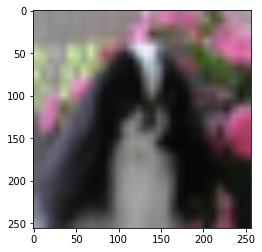

0 0.9058869481086731


In [9]:
img, _ = data[42]
plt.imshow(img.permute(1, 2, 0))
plt.show()

img = img.unsqueeze(0).to(device)
moco.eval()
with torch.no_grad():
    logits, y = moco(img)
    loss = loss_fn(logits, y)
print(logits.argmax(-1).item(), loss.item())